In [3]:
from FlagEmbedding import BGEM3FlagModel
import os
import numpy as np
import json
from transformers import AutoTokenizer
from tqdm import tqdm
import pandas as pd
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/joseacentic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
model = BGEM3FlagModel('BAAI/bge-m3',  use_fp16=True)

Fetching 22 files: 100%|██████████| 22/22 [00:00<?, ?it/s]


In [18]:
sentence1 = 'Hola'
sentence2 = 'Buenos días'

emb1 = model.encode(sentence1)['dense_vecs']
emb2 = model.encode(sentence2)['dense_vecs']

emb1 @ emb2


0.72925144

In [3]:
with open('./DATA/articles.json', 'r') as articlesFile:
    articles =  json.load(articlesFile)

In [35]:
#Eliminar tickets que tengan mas de 8192 tokens 
#encontrar el tokenizador que usa BGE-m3
tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-m3')

In [36]:
def tok(cadena):
    return tokenizer.encode(cadena)

In [29]:
#Extraer embedings de los articulos:

valid_articles = []

for article in tqdm(articles):

    tokens = len(tok(article['body']))

    if tokens <= 8192:
        article['emb_body'] = model.encode(article['body'])['dense_vecs']
        valid_articles.append(article)
    else:
        print(f"El articulo {article['id']} supera el numero máximo de tokens permitidos. Tiene {tokens} tokens.")

 19%|█▉        | 59/310 [25:45<2:49:56, 40.62s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (9302 > 8192). Running this sequence through the model will result in indexing errors


El articulo 360015286579 supera el numero máximo de tokens permitidos. Tiene 9302 tokens.


 55%|█████▍    | 170/310 [1:08:13<19:30,  8.36s/it]  

El articulo 7740012887324 supera el numero máximo de tokens permitidos. Tiene 10361 tokens.


 79%|███████▊  | 244/310 [1:37:10<15:16, 13.89s/it]  

El articulo 7873107334812 supera el numero máximo de tokens permitidos. Tiene 12409 tokens.


100%|██████████| 310/310 [1:56:49<00:00, 22.61s/it]


In [39]:
for a in valid_articles:
    a['emb_body'] = a['emb_body'].tolist()

In [40]:
#guardamos los embeddings
with open('./DATA/articles_emb_bgem3.json','w') as f:
    f.write(json.dumps(valid_articles, indent = 4))

In [4]:
#lectura de embeddings: 
with open('./DATA/articles_emb_bgem3.json','r') as f: 
    valid_articles = json.load(f)

In [5]:
def calculaDistancia(pregunta, limit):
    df = pd.DataFrame(columns = ['id','title', 'emb'])
    print(pregunta)
    for a in valid_articles:
        dic = {}
        dic['id'] = [a['id']]
        dic['title'] = [a['title']]
        dic['emb'] = [a['emb_body']]
        #df = df.append(dic, ignore_index = True)
        df = pd.concat([df, pd.DataFrame(dic, index=[0])], ignore_index=True)

    #convertimos la pregunta a embedding:
    emb_preg = model.encode(pregunta)['dense_vecs'] 
    df['distancia'] = df['emb'].apply(lambda x: np.array(x) @ emb_preg)
    df = df.sort_values('distancia', ascending = False)
    return df.head(limit)

In [37]:
calculaDistancia('Cómo fidelizar a tus compradores de Hot Sale',10)

Cómo fidelizar a tus compradores de Hot Sale


,id,title,emb,distancia
129,6029655913116,Cupón a compradores,"[-0.06487193703651428, -0.010833361186087132, ...",0.602504
22,6049188771484,Acceso preferente a clientes de alto valor,"[-0.06495802849531174, 0.0005379398935474455, ...",0.601404
170,6024083408028,Última oportunidad para recuperar carritos,"[-0.019485460594296455, -0.0008154058596119285...",0.576391
0,8764508351644,Workflows Hot Sale 2023,"[-0.052947767078876495, -0.011344102211296558,...",0.575200
154,4406098978194,Up selling,"[-0.03890165314078331, -0.03597082197666168, -...",0.552800
190,6017479478300,Remarketing según RFM,"[-0.029272165149450302, -0.009745901450514793,...",0.539744
151,6321585214226,Reactivación de compradores estacionales,"[-0.022547071799635887, 0.013216782361268997, ...",0.530191
103,4407779448338,Recomendador de best sellers en ficha de producto,"[-0.06646508723497391, -0.0016724533634260297,...",0.516854
294,4410740280594,Recomendador de productos para clientes indecisos,"[-0.015073684975504875, -3.570366607164033e-05...",0.514198
188,7869328014236,[LBD] Añade a tus fichas de producto un inline...,"[-0.03760378062725067, -0.0034601751249283552,...",0.513464


<h3> Preprocesamiento de texto </h3>

In [6]:
def elimina_puntuacion(cadena):
    return " ".join("".join(["" if p in string.punctuation else p for p in cadena]).split())

def elimina_stopwords(cadena):
    lista_stop = stopwords.words('spanish')
    return ' '.join([word for word in cadena.split() if word not in lista_stop])

def elimina_urls(cadena):
    return re.compile(r'https?://\S+|www\.\S+').sub('',cadena)

def elimina_correos(cadena):
    return re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b').sub('',cadena)

def elimina_imagenes(cadena):
    return re.compile(r'\b[A-Za-z0-9]+\.+png\b').sub('',cadena)

def preprocesador(cadena):
    return elimina_stopwords(elimina_puntuacion(elimina_imagenes(elimina_urls(elimina_correos(cadena)))))


In [33]:
for a in articles:
    a['body'] = preprocesador(a['body'])

In [37]:
valid_articles_p = []

for article in tqdm(articles):

    tokens = len(tok(article['body']))

    if tokens <= 8192:
        article['emb_body'] = model.encode(article['body'])['dense_vecs']
        valid_articles_p.append(article)
    else:
        print(f"El articulo {article['id']} supera el numero máximo de tokens permitidos. Tiene {tokens} tokens.")

100%|██████████| 310/310 [29:22<00:00,  5.69s/it]  


In [ ]:
for a in valid_articles_p:
    a['emb_body'] = a['emb_body'].tolist()

In [40]:
with open('./DATA/articles_emb_prepro_bgem3.json','w') as f:
    f.write(json.dumps(valid_articles_p, indent = 4))

In [7]:
with open('./DATA/articles_emb_prepro_bgem3.json', 'r') as f:
    valid_articles_p = json.load(f)

In [8]:
def calculaDistancia_p(pregunta, limit):
    df = pd.DataFrame(columns = ['id','title', 'emb'])
    print(pregunta)
    for a in valid_articles_p:
        dic = {}
        dic['id'] = [a['id']]
        dic['title'] = [a['title']]
        dic['emb'] = [a['emb_body']]
        #df = df.append(dic, ignore_index = True)
        df = pd.concat([df, pd.DataFrame(dic, index=[0])], ignore_index=True)

    #convertimos la pregunta a embedding:
    emb_preg = model.encode(pregunta)['dense_vecs'] 
    df['distancia'] = df['emb'].apply(lambda x: np.array(x) @ emb_preg)
    df = df.sort_values('distancia', ascending = False)
    return df.head(limit)

In [35]:
calculaDistancia_p('Cómo fidelizar a tus compradores de Hot Sale',10)

Cómo fidelizar a tus compradores de Hot Sale


,id,title,emb,distancia
22,6049188771484,Acceso preferente a clientes de alto valor,"[-0.0389719232916832, -0.02095450833439827, -0...",0.628544
192,6017479478300,Remarketing según RFM,"[-0.04319767281413078, -0.022214515134692192, ...",0.574524
130,6029655913116,Cupón a compradores,"[-0.05453833192586899, -0.03135461360216141, -...",0.572055
0,8764508351644,Workflows Hot Sale 2023,"[-0.04387192055583, -0.02086762525141239, -0.0...",0.560615
172,6024083408028,Última oportunidad para recuperar carritos,"[-0.006840522401034832, -0.030226707458496094,...",0.549168
155,4406098978194,Up selling,"[-0.028238147497177124, -0.06096935644745827, ...",0.533497
7,7116448367260,Lead Nurturing Postventa,"[-0.10121337324380875, -0.042496293783187866, ...",0.521280
152,6321585214226,Reactivación de compradores estacionales,"[-0.003967236261814833, -0.013972432352602482,...",0.511771
8,7087098296604,Lead Nurturing Preventa,"[-0.09788084775209427, -0.03071371279656887, -...",0.500910
174,6849722079122,Última compra hace 30d,"[-0.03889849781990051, -0.042348314076662064, ...",0.494608


<h2> Evaluación</h2>

In [61]:
art_deletes = [360015286579,7740012887324,7873107334812]
for a in valid_articles_p:
    if a['id'] in art_deletes:
        print(f"Id: {a['id']} title: {a['title']}")

Id: 360015286579 title: Historial de cambios
Id: 7740012887324 title: [LBD] Crea tu funnel de carrito abandonado
Id: 7873107334812 title: [LBD] Crea una campaña de recomendaciones personalizadas en base al valor RFM del usuario 


<h3> Representación gráfica </h3>

In [30]:
#Pruebas: 

pregunta = 'Cómo fidelizar a tus compradores de Hot Sale'
#pregunta = 'Necesito meter muchas url en el nodo'
emb_pregunta = model.encode(pregunta)['dense_vecs']
#emb_respuesta =  np.array(eval(calculaDistancia_p(pregunta,10).loc[0,'emb']))
#Hay que coger un conjunto de embeddings (p.e 300) para reducir la dimensionalidad... 
#El formato del vector debe ser el siguiente: array con shape = (621,1024)
#Concatenación de 3 dataframes, el primero de las preguntas, el segundo embeddings sin procesar y el ultimo con el preprocesamiento
dic_preg =  {
    'id':[0],
    'title':[pregunta],
    'emb': [model.encode(pregunta)['dense_vecs'].tolist()],
    'distancia': [1.0] 
}
df_pregunta = pd.DataFrame(dic_preg, index=[0])
df_pregunta['Color'] = 'black'
df_emb1 = calculaDistancia(pregunta,310)
df_emb1['Color'] = 'red'
df_emb2 = calculaDistancia_p(pregunta,310)
df_emb2['Color'] = 'blue'

df_comp = pd.concat([df_pregunta,df_emb1,df_emb2], ignore_index= True)
df_comp

#Ahora hay que hacer TSNE para reducir componentes emb_dim2 por ejemplo nueva columna
#Se puede hacer una variable tipo emb = [[],[],...,[]] y a esa se le aplica tsne, y la que te da resultado se hace un merge en el dataframe



tsne = TSNE(n_components=2, random_state=42)

emb_dim2 = tsne.fit_transform(np.array(df_comp['emb'].tolist()))
emb_dim2
df = pd.DataFrame({'emb_dim2': emb_dim2.tolist()})
#df
df_comp = pd.merge(df_comp,df, left_index=True, right_index=True)
df_comp['emb_dim2_x'] = df_comp['emb_dim2'].apply(lambda x: x[0])
df_comp['emb_dim2_y'] = df_comp['emb_dim2'].apply(lambda x: x[1])
df_comp.head()

Cómo fidelizar a tus compradores de Hot Sale
Cómo fidelizar a tus compradores de Hot Sale


,id,title,emb,distancia,Color,emb_dim2,emb_dim2_x,emb_dim2_y
0,0,Cómo fidelizar a tus compradores de Hot Sale,"[-0.061005428433418274, -0.04074331372976303, ...",1.000000,black,"[-18.814311981201172, -16.702669143676758]",-18.814312,-16.702669
1,6029655913116,Cupón a compradores,"[-0.06487193703651428, -0.010833361186087132, ...",0.602504,red,"[-26.083066940307617, -3.1943037509918213]",-26.083067,-3.194304
2,6049188771484,Acceso preferente a clientes de alto valor,"[-0.06495802849531174, 0.0005379398935474455, ...",0.601404,red,"[-19.03435516357422, -14.837255477905273]",-19.034355,-14.837255
3,6024083408028,Última oportunidad para recuperar carritos,"[-0.019485460594296455, -0.0008154058596119285...",0.576391,red,"[-32.64750289916992, -20.16671371459961]",-32.647503,-20.166714
4,8764508351644,Workflows Hot Sale 2023,"[-0.052947767078876495, -0.011344102211296558,...",0.575200,red,"[-19.03567886352539, -19.623891830444336]",-19.035679,-19.623892


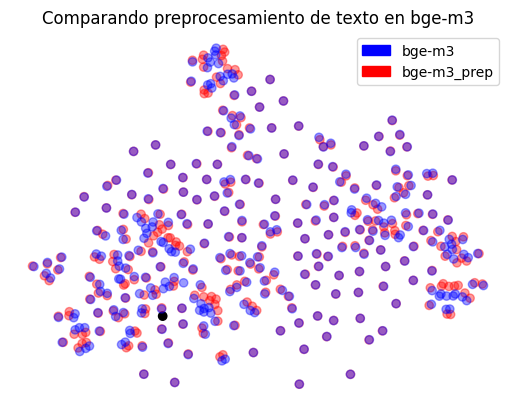

In [31]:
#Representación gráfica.
x = df_comp['emb_dim2_x']
y = df_comp['emb_dim2_y']
color = df_comp['Color']

alphas = [0.4] * len(x)
index_pregunta = 0
alphas[index_pregunta] = 1

plt.scatter(x,y,c = color, alpha=alphas)

custom_handles = [ plt.Rectangle((0,0),1,1, color = 'Blue'),
                   plt.Rectangle((0,0),1,1, color  = 'Red')]

custom_labels = ['bge-m3','bge-m3_prep']

plt.legend(custom_handles,custom_labels)
plt.title('Comparando preprocesamiento de texto en bge-m3')
plt.axis('off')
plt.show()
#hacer otro grafico donde se tomen menos puntos (solo los mas cercanos) y se vea su id


C:\Users\josea\AppData\Local\Temp\ipykernel_22920\3303604271.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top10 = df_comp.groupby('Color').apply(lambda x: x.nlargest(n, 'distancia')).reset_index(drop=True)


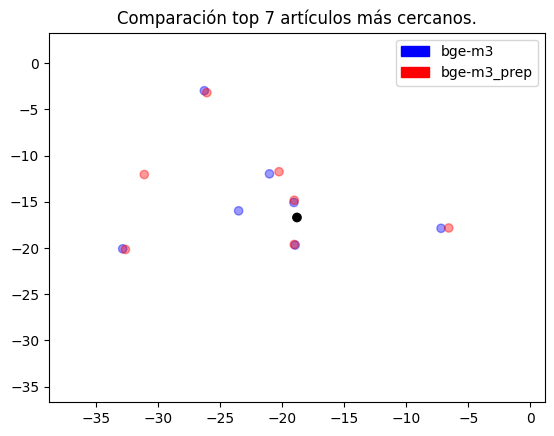

In [32]:
n = 7 #Numero de elementos más cercanos
df_top10 = df_comp.groupby('Color').apply(lambda x: x.nlargest(n, 'distancia')).reset_index(drop=True)
x = df_top10['emb_dim2_x']
y = df_top10['emb_dim2_y']
color = df_top10['Color']

alphas = [0.4] * len(x)
index_pregunta = 0
alphas[index_pregunta] = 1

plt.scatter(x,y,c = color, alpha=alphas)

#for i, row in df_top10.iterrows():
#    plt.text(row['emb_dim2_x'], row['emb_dim2_y'], str(row['title']), fontsize=10, ha='center', va='bottom')

plt.xlim((df_top10.loc[0,'emb_dim2_x']-20,df_top10.loc[0,'emb_dim2_x']+20))
plt.ylim((df_top10.loc[0,'emb_dim2_y']-20,df_top10.loc[0,'emb_dim2_y']+20))

custom_handles = [ plt.Rectangle((0,0),1,1, color = 'Blue'),
                   plt.Rectangle((0,0),1,1, color  = 'Red')]

custom_labels = ['bge-m3','bge-m3_prep']

plt.legend(custom_handles,custom_labels)
plt.title(f'Comparación top {n} artículos más cercanos.')
#plt.axis('off')
plt.show()

In [33]:
df_top10

,id,title,emb,distancia,Color,emb_dim2,emb_dim2_x,emb_dim2_y
0,0,Cómo fidelizar a tus compradores de Hot Sale,"[-0.061005428433418274, -0.04074331372976303, ...",1.000000,black,"[-18.814311981201172, -16.702669143676758]",-18.814312,-16.702669
1,6049188771484,Acceso preferente a clientes de alto valor,"[-0.0389719232916832, -0.02095450833439827, -0...",0.628544,blue,"[-19.05695343017578, -15.078132629394531]",-19.056953,-15.078133
2,6017479478300,Remarketing según RFM,"[-0.04319767281413078, -0.022214515134692192, ...",0.574524,blue,"[-21.03192710876465, -11.980491638183594]",-21.031927,-11.980492
3,6029655913116,Cupón a compradores,"[-0.05453833192586899, -0.03135461360216141, -...",0.572055,blue,"[-26.28464126586914, -2.9833273887634277]",-26.284641,-2.983327
4,8764508351644,Workflows Hot Sale 2023,"[-0.04387192055583, -0.02086762525141239, -0.0...",0.560615,blue,"[-18.95890998840332, -19.689701080322266]",-18.958910,-19.689701
5,6024083408028,Última oportunidad para recuperar carritos,"[-0.006840522401034832, -0.030226707458496094,...",0.549168,blue,"[-32.868988037109375, -20.094663619995117]",-32.868988,-20.094664
6,4406098978194,Up selling,"[-0.028238147497177124, -0.06096935644745827, ...",0.533497,blue,"[-7.194425106048584, -17.875408172607422]",-7.194425,-17.875408
7,7116448367260,Lead Nurturing Postventa,"[-0.10121337324380875, -0.042496293783187866, ...",0.521280,blue,"[-23.520395278930664, -15.983078002929688]",-23.520395,-15.983078
8,6029655913116,Cupón a compradores,"[-0.06487193703651428, -0.010833361186087132, ...",0.602504,red,"[-26.083066940307617, -3.1943037509918213]",-26.083067,-3.194304
9,6049188771484,Acceso preferente a clientes de alto valor,"[-0.06495802849531174, 0.0005379398935474455, ...",0.601404,red,"[-19.03435516357422, -14.837255477905273]",-19.034355,-14.837255


<h3> Comparación con modelo de <i> hiiamsid </i></h3>

In [13]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import Normalizer

In [14]:
#Comparamos modelos emb sin hacer el preprocesamiento de texto
with open('./DATA/articles_embeddings.json','r') as f:
    articles_sid = json.load(f)

In [15]:
model_sid = SentenceTransformer("./modelo")

normalizer = Normalizer(norm='l2')

def calculaDistancia_sid(pregunta, limit):
    df = pd.DataFrame(columns = ['id','title', 'emb'])
    print(pregunta)
    for a in articles_sid:
        dic = {}
        dic['id'] = a['id']
        dic['title'] = a['title']
        dic['emb'] = a['emb_body']
        #df = df.append(dic, ignore_index = True) 
        df = pd.concat([df, pd.DataFrame(dic, index=[0])], ignore_index=True)

    #convertimos la pregunta a embedding:
    emb_preg = normalizer.transform(model_sid.encode([pregunta]))
    df['distancia'] = df['emb'].apply(lambda x: np.array(x) @ emb_preg[0])
    df = df.sort_values('distancia', ascending = False)
    return df.head(limit)

In [35]:
#Necesitamos: 
#mover los puntos de bge al sistema de referencia centrado en (0,0) hacer lo mismo con sid
#una vez hecho eso, coger el top 5 de sid y buscarlas en bge. 
#Del mismo color se representan esas 5 preguntas pero con distinto alpha. 
#Mostrar de un color diferente todas las preguntas mas cercanas que hay con el modelo bge. 

#Pasamos sid al sistema de refencia 00
pregunta = 'Cómo fidelizar a tus compradores de Hot Sale'
#pregunta = 'Necesito meter muchas url en el nodo'
emb_pregunta = model_sid.encode([pregunta])

df_sid = calculaDistancia_sid(pregunta,310)

dic_preg =  {
    'id':[0],
    'title':[pregunta],
    'emb': model_sid.encode([pregunta]).tolist(),
    'distancia': [1.0] 
}
df_pregunta = pd.DataFrame(dic_preg, index=[0])
df_pregunta['Color'] = 'Black'
df_sid['Color'] = 'Red'
df_sid = pd.concat([df_pregunta, df_sid], ignore_index=True)

tsne = TSNE(n_components=2, random_state=42)

emb_dim2_sid = tsne.fit_transform(np.array(df_sid['emb'].tolist()))
df = pd.DataFrame({'emb_dim2': emb_dim2_sid.tolist()})

df_sid = pd.merge(df_sid,df, left_index=True, right_index=True)

df_sid['emb_dim2_x'] = df_sid['emb_dim2'].apply(lambda x: x[0])
df_sid['emb_dim2_y'] = df_sid['emb_dim2'].apply(lambda x: x[1])
emb_pregunta_dim2 = df_sid.loc[0,'emb_dim2']
emb_pregunta_dim2
df_sid['emb_dim2_x_SF'] = df_sid['emb_dim2_x'].apply(lambda x: x-emb_pregunta_dim2[0])
df_sid['emb_dim2_y_SF'] = df_sid['emb_dim2_y'].apply(lambda x: x-emb_pregunta_dim2[1])
#df_sid

Cómo fidelizar a tus compradores de Hot Sale


Representamos los 5 artículos más cercanos en el modelo Sid centrando la pregunta en el (0,0)

C:\Users\josea\AppData\Local\Temp\ipykernel_22920\3272512844.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top10_sid = df_sid.groupby('Color').apply(lambda x: x.nlargest(n, 'distancia')).reset_index(drop=True)


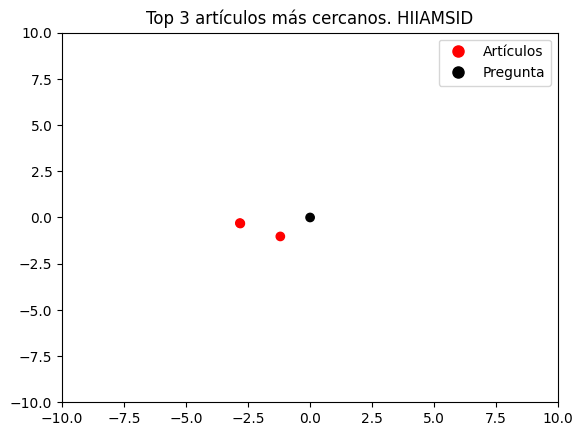

In [36]:
n =3 #Numero de elementos más cercanos
df_top10_sid = df_sid.groupby('Color').apply(lambda x: x.nlargest(n, 'distancia')).reset_index(drop=True)
x = df_top10_sid['emb_dim2_x_SF']
y = df_top10_sid['emb_dim2_y_SF']
color = df_top10_sid['Color']

#alphas = [0.4] * len(x)
#index_pregunta = 0
#alphas[index_pregunta] = 1

plt.scatter(x,y,c = color)#, alpha=alphas)

#for i, row in df_top10.iterrows():
#    plt.text(row['emb_dim2_x'], row['emb_dim2_y'], str(row['title']), fontsize=10, ha='center', va='bottom')

plt.xlim((df_top10_sid.loc[0,'emb_dim2_x_SF']-10,df_top10_sid.loc[0,'emb_dim2_x_SF']+10))
plt.ylim((df_top10_sid.loc[0,'emb_dim2_y_SF']-10,df_top10_sid.loc[0,'emb_dim2_y_SF']+10))

custom_handles = [plt.Line2D([], [], marker='o', markersize=8, color='Red', linestyle='None'),
                  plt.Line2D([], [], marker='o', markersize=8, color='Black', linestyle='None')]
custom_labels = ['Artículos','Pregunta']

plt.legend(custom_handles,custom_labels)
plt.title(f'Top {n} artículos más cercanos. HIIAMSID')
#plt.axis('off')
plt.show()

C:\Users\josea\AppData\Local\Temp\ipykernel_22920\1080879362.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top10 = df_comp.groupby('Color').apply(lambda x: x.nlargest(n, 'distancia')).reset_index(drop=True)


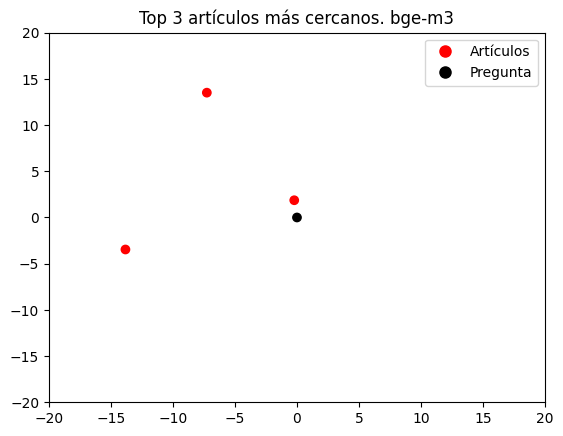

In [37]:
#Hacemos lo mismo pero con los artículos de bge: #Podemos usar el dataframe df_Comp que es el que se ha trabajado arriba 
#solo tenemos que hacerle el cambio de sistema de referencia
df_comp = df_comp[df_comp['Color'] != 'blue']
emb_pregunta_dim2 = df_comp.loc[0,'emb_dim2']
df_comp['emb_dim2_x_SF'] = df_comp['emb_dim2_x'].apply(lambda x: x-emb_pregunta_dim2[0])
df_comp['emb_dim2_y_SF'] = df_comp['emb_dim2_y'].apply(lambda x: x-emb_pregunta_dim2[1])

n =3 #Numero de elementos más cercanos
df_top10 = df_comp.groupby('Color').apply(lambda x: x.nlargest(n, 'distancia')).reset_index(drop=True)
x = df_top10['emb_dim2_x_SF']
y = df_top10['emb_dim2_y_SF']
color = df_top10['Color']

#alphas = [0.4] * len(x)
#index_pregunta = 0
#alphas[index_pregunta] = 1

plt.scatter(x,y,c = color)#, alpha=alphas)

#for i, row in df_top10.iterrows():
#    plt.text(row['emb_dim2_x'], row['emb_dim2_y'], str(row['title']), fontsize=10, ha='center', va='bottom')

plt.xlim((df_top10.loc[0,'emb_dim2_x_SF']-20,df_top10.loc[0,'emb_dim2_x_SF']+20))
plt.ylim((df_top10.loc[0,'emb_dim2_y_SF']-20,df_top10.loc[0,'emb_dim2_y_SF']+20))

custom_handles = [plt.Line2D([], [], marker='o', markersize=8, color='Red', linestyle='None'),
                  plt.Line2D([], [], marker='o', markersize=8, color='Black', linestyle='None')]
custom_labels = ['Artículos','Pregunta']

plt.legend(custom_handles,custom_labels)
plt.title(f'Top {n} artículos más cercanos. bge-m3')
#plt.axis('off')
plt.show()

In [ ]:
#Coger el df_bge de los 5 mejores y hacer un dataframe de iamsid que incluya esos cinco mas los más cercanos a ver cuantos hay y donde los situa

df_top10['title'].tolist()

d_min = df_sid[df_sid['title'].isin(df_top10['title'].tolist())]['distancia'].min()

#Todos los articulos sid con mejor aproximacion que el peor de los 3 mejores de bge 
df_sid_filtrados = df_sid[df_sid['distancia']>d_min]

df_sid_filtrados['Color'] = df_sid_filtrados['Color'].where(df_sid_filtrados['title'].isin(df_top10['title']), 'blue')

#df_sid_filtrados

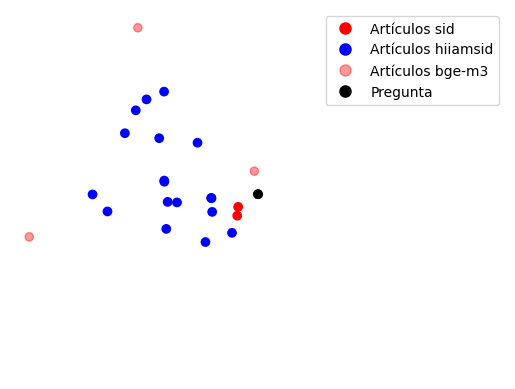

In [39]:
x = df_top10['emb_dim2_x_SF']
y = df_top10['emb_dim2_y_SF']
color = df_top10['Color']

alphas = [0.4] * len(x)
index_pregunta = 0
alphas[index_pregunta] = 1

plt.scatter(x,y,c = color, alpha=alphas)
plt.scatter(df_sid_filtrados['emb_dim2_x_SF'],df_sid_filtrados['emb_dim2_y_SF'],c = df_sid_filtrados['Color'])
#for i, row in df_top10.iterrows():
#    plt.text(row['emb_dim2_x'], row['emb_dim2_y'], str(row['title']), fontsize=10, ha='center', va='bottom')

plt.xlim((df_top10.loc[0,'emb_dim2_x_SF']-15,df_top10.loc[0,'emb_dim2_x_SF']+15))
plt.ylim((df_top10.loc[0,'emb_dim2_y_SF']-15,df_top10.loc[0,'emb_dim2_y_SF']+15))

custom_handles = [plt.Line2D([], [], marker='o', markersize=8, color='Red', linestyle='None'),
                  plt.Line2D([], [], marker='o', markersize=8, color='Blue', linestyle='None'),
                  plt.Line2D([], [], marker='o', markersize=8, color='Red', linestyle='None', alpha = 0.4),
                  plt.Line2D([], [], marker='o', markersize=8, color='Black', linestyle='None')]
custom_labels = ['Artículos sid','Artículos hiiamsid','Artículos bge-m3','Pregunta']

plt.legend(custom_handles,custom_labels)
#plt.title(f'Top {n} artículos más cercanos. bge-m3')
plt.axis('off')
plt.show()


Este gráfico indica que un modelo es mejor que otro? En este caso concreto NO

Los dos modelos actuan bien en esta pregunta. ¿Por qué?
En rojo difuminado tenemos las 3 mejores articulos para el modelo bge
En rojo tenemos los 3 mejores articulos para el modelo hiiamsid. Estos, se encuentran en una buena posición respecto a los modelos puntos rojos que son los articulos hiiamsid ya que son los primeros en estar más cerca de la pregunta 

Tendríamos más problemas si entre los circulos rojos y el punto pregunta estuvieran muchos puntos azules, que no es el caso, casualmetne en esta pregunta todo funciona perfecto, es decir, de momento, los dos modelos parecen buenos. 

Nota: Hacer con más preguntas a ver como actuan

In [109]:

##IGNORAR

df_sid = calculaDistancia_sid(pregunta,310)
df_bge = calculaDistancia(pregunta,310)

print(len(df_sid.loc[0,'emb']))
print(len(df_bge.loc[0,'emb']))

#No vale, no tiene sentido este planteamiento
df_conjunto = pd.concat([df_sid,df_bge], ignore_index= True)
df_conjunto['emb'].tolist()
1024

df_conjunto['emb_1024'] = df_conjunto['emb'].apply(lambda x: np.pad(x, (0, 1024 - len(x)), mode='constant', constant_values=0))
df_conjunto.loc[0,'emb_1024']

#tsne = TSNE(n_components=2, random_state=42)

#emb_dim2 = tsne.fit_transform(np.array(df_conjunto['emb'].tolist()))
#emb_dim2

#df = pd.DataFrame({'emb_dim2': emb_dim2.tolist()})
#df
#df_conjunto = pd.merge(df_conjunto,df, left_index=True, right_index=True)
#df_conjunto['emb_dim2_x'] = df_conjunto['emb_dim2'].apply(lambda x: x[0])
#df_conjunto['emb_dim2_y'] = df_conjunto['emb_dim2'].apply(lambda x: x[1])
#df_conjunto.head()


Cómo fidelizar a tus compradores de Hot Sale
Cómo fidelizar a tus compradores de Hot Sale
768
1024


array([ 0.00156336, -0.01800038, -0.01080883, ...,  0.        ,
        0.        ,  0.        ])

In [4]:
#Coste computacional distancia coseno, distancia de manhattan y distancia euclidea 
#vectores de 768 

#Distancia de manhattan: + valor abs de cada componente + 768
#dim2 --> 2 restas y una suma
#dim3 --> 3 restas y dos sumas 
#----
#dim n -> n restas y n-1 sumas 

#Total: 768 restas + 767 sumas 1535 operaciones sin contar el abs --------- contando abs : 2303

#Distancia del coseno: 
#suponemos que los vectores estan normalizados:
#dim2 --> dos multiplicaciones y una suma  
#dim3 --> tres multiplicaciones y dos sumas
#----
#dim n -> n multiplicaciones y n-1 sumas

#Total: 768 multiplicaciones y 767 sumas 1535 operaciones 

#Distancia euclidea: 

#dim2 --> dos restas dos cuadrados una suma y una raiz
#dim3 --> tres restas tres cuadrados dos sumas y una raiz
#----
#dim n -> n restas n cuadrados n-1 sumas y una raiz

#Total: 768 restas 768 cuadrados 767 sumas y una raiz 2304


2303